## 聚类算法
我们之前在讲EM算法时，使用的例子GMM和K-means就是非常经典且强大的聚类方法。这种方法不依赖标签就能进行，在连续数据分布上尤其实用。我们把这一大类的无监督算法都归类到无监督学习的类别里。下面我们还会介绍一些其他的经典聚类算法。

### K-means方法
GMM的极简版本，超简单的聚类方法。根据原型向量生成球形簇，再由球形簇更新原型向量。  
**算法**  
1、随机初始化k个原型向量  
2、对每个数据点计算最靠近的原型向量  
3、设2步骤生成的，每个原型向量附近的数据点集合为S，更新原型向量为S中所有向量的均值。  
4、回到第2步，直到最大迭代次数或者所有原型向量都不再更新。  
算法的优点在于运行速度很快，但是如果数据分布不是球形簇，则很有可能得到不理想的结果。

In [1]:
import numpy as np
import random
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt 
from sklearn.metrics import accuracy_score
import warnings
from sklearn import datasets

In [2]:
X,y = datasets.load_iris(return_X_y=True)

In [3]:
def Dist(x1,x2):
    #Minkowski distance
    p = len(x1)
    return np.sum((x1-x2)**p)**(1/p)

In [4]:
def Kmeans(data,k):
    data = list(data)
    us = random.sample(data,k)
    N = len(data)
    labels = [0 for _ in range(N)]#聚类标签
    while(1):
        for j in range(N):
            for i in range(k):
                c = labels[j]
                if Dist(us[i],data[j])<Dist(us[c],data[j]):
                    labels[j] = i
        new_us = [np.zeros(len(data[0])) for _ in range(k)]
        counter = [0 for _ in range(k)]
        for j in range(N):
            c = labels[j]
            new_us[c] += data[j]
            counter[c]+=1
        flag = 1
        for i in range(k):
            new_us[i]/=counter[i]
            if (new_us[i]!=us[i]).all():
                flag = 0
        if flag:
            return labels
        us = new_us
    return None

iris数据集是经典的类球形簇，用k-means可以得到蛮不错的效果。

Text(0.5,1,'Distribution by Kmeans')

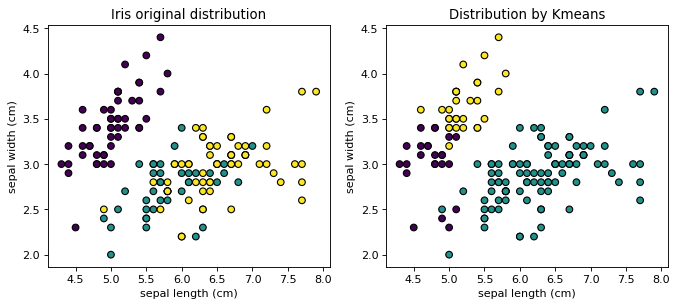

In [5]:
labels = Kmeans(X,3)
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1],edgecolors='black',
            c=y)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Iris original distribution')
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1],edgecolors='black',
            c=labels)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Distribution by Kmeans')

### DBSCAN
基于图论的聚类算法，我们设一个距离阈值，如果两点之间距离低于阈值则视为两点连通。连通与否会把数据分成几个block，我们再设置一个数量阈值，如果一个数据点附近连通的点的数目多于阈值就认为它自成一簇，这种点被叫做核心对象。我们对每个核心对象执行BFS寻找最大连通域。最后，所有超过阈值的核心对象都会被访问。如果还留有一些无法被归类到任何一个簇的数据，则视为异常点。  
**算法**  
1、初始化阈值epsilon和minpts  
2、对每个数据点计算和其他数据点的连通情况  
3、对每个数据点计算连通总数，判断它是不是核心对象  
4、for 所有核心对象:  
$\quad$ 如果该核心对象未访问过，对它执行BFS  
$\quad$ BFS过程中找到的所有其他未访问过的数据，和该核心对象形成集合S  
$\quad$ S中的数据点被归类到新的簇  
5、返回聚类情况  
这个算法比起K-means有一定的优越性，因为它能学习流形，而K-means只能学习球形簇。但是计算连通性和连通矩阵将是O(N^2)级别的时间开销，这在非常大的数据集上有可能不适用。而且DBSCAN需要自己调节参数，在我们不了解数据集的性质时，我们可能很难给出一个合适的参数。

In [6]:
#密度聚类，使用密度可达关系导出连通性
#基于连通性定理把数据分块
import queue

def DBscan(data,epsilon,minpts):
    core = set()
    L = len(data)
    AM = [[0 for _ in range(L)] for _ in range(L)]#联通与否使用bool值表示
    #建立初步邻接矩阵并确定核心对象
    for i in range(L):
        for j in range(L):
            AM[i][j] = (Dist(data[i],data[j])<epsilon)
    #不考虑本身时，密度直达的点的数目大于等于minpts，则该点为core object
    for i in range(L):
        if sum(AM[i])-1>=minpts:
            core.add(i)
    visited = set()#使用集合表示是否被访问过
    #实行广度优先搜索获得多个簇
    cluster_cnt = 0
    labels = [-1 for _ in range(L)]#-1表示该点不属于任何一个核心对象的簇，即异常值
    while (len(core)):
        #随机获取一个core object
        co = core.pop()
        if co in visited:
            continue
        q = queue.Queue()
        q.put(co)
        while (not q.empty()):
            p = q.get()
            labels[p] = cluster_cnt#置p为第n个簇
            visited.add(p)
            for i in range(L):
                if AM[p][i] and p!=i and (i not in visited):
                    q.put(i)
        cluster_cnt += 1
    return labels

我们跑一个学习流形的例子，来体验下DBSCAN的效果。

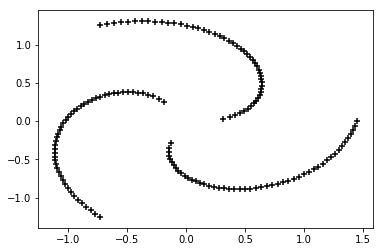

In [7]:
theta1 = np.linspace(0.1,np.pi*2/3,50)
theta2 = theta1 + np.pi*2/3
theta3 = theta2 + np.pi*2/3
r = theta1**0.5
xx1 = r*np.cos(theta1)
yy1 = r*np.sin(theta1)
xx2 = r*np.cos(theta2)
yy2 = r*np.sin(theta2)
xx3 = r*np.cos(theta3)
yy3 = r*np.sin(theta3)
xx = np.concatenate((xx1,xx2,xx3))
yy = np.concatenate((yy1,yy2,yy3))
X = np.concatenate((xx[None],yy[None]),axis = 0).T

plt.scatter(xx,yy,marker = '+',c = 'black')

Text(0.5,1,'Clusters by DBSCAN')

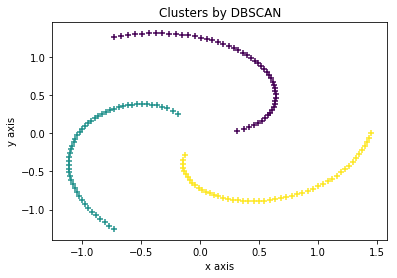

In [8]:
labels = DBscan(X,0.1,3)
plt.scatter(X[:,0], X[:,1], marker = '+',c=labels)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('Clusters by DBSCAN')

### AGNES
AGNES的策略是，一开始把所有数据点单独作为一个簇，然后不断执行两个簇合并成一个簇的操作。这个操作的核心在于如何选取要合并哪两个簇，评判两个簇间距一种有效的度量方法是使用Hausdorff distance。它计算簇A中每个点，到达簇B任意一点的最短距离，再在这些距离中取最大。  
每次合并后，都要更新新生成的簇与其他簇的HD，这个HD的计算其实并不简单，它要遍历A、B所有的元素O(N^2)级别。所以ANGES也是一种在大型的数据集上表现得较慢的算法。  
**算法**  
1、对N个数据点，初始化N个簇  
2、初始化每两个簇间的距离矩阵M  
3、寻找最近的两个簇i、j  
4、把i、j两个簇合并成一个  
5、从距离矩阵M中删除i、j，添加新的一行一列k  
6、计算k到其他所有簇的簇间距  
7、如果当前簇数量仍然大于目标簇数K，回到3迭代
8、返回聚类情况  
算法在大多数情况都能表现得不错，但是在样本分布不均匀时很有可能得到数量不平衡的解。而且它的运行速度要比DBSCAN更慢。

In [9]:
def synthesis_dist(a, b):
    D = [[Dist(a[i], b[j]) for j in range(len(b))] for i in range(len(a))]
    minz = []
    for z in range(len(b)):
        minz.append(min(D[x][z] for x in range(len(a))))
    minx = []
    for x in range(len(a)):
        minx.append(min(D[x][z] for z in range(len(b))))
    return max(max(minz),max(minx))

def hierarchical_clustering(data, k):
    #初始化n个簇，每个簇只有一个元素
    clusters = [[ele] for ele in data]
    N = len(data)
    M = np.zeros((N,N))
    INF = float("inf")
    #设置簇与自身的dist为无穷大，因为簇不可能与自身合并
    for i in range(N):
        M[i][i] = INF
        for j in range(i+1,N):
            M[i][j] = synthesis_dist(clusters[i],clusters[j])
            M[j][i] = M[i][j]
    while(len(clusters)>k):
        #寻找距离最近的两个簇
        L =len(clusters)
        cur_dist = M[0][0]
        curi = curj = 0
        for i in range(L):
            for j in range(i+1,L):
                if cur_dist>M[i][j]:
                    cur_dist = M[i][j]
                    curi = i
                    curj = j
        #合并i、j两簇，并删除clusters和M中的i、j行列
        clusters[curi].extend(deepcopy(clusters[curj]))
        clusters.pop(curj)
        index = np.arange(0,L)
        index = np.delete(index,curj)
        M = M[:,index][index]
        #更新距离矩阵
        for j in range(L-1):
            if curi==j:
                M[curi][j]=INF
                M[j][curi]=INF
            else:
                D = synthesis_dist(clusters[curi],clusters[j])
                M[curi][j] = D
                M[j][curi] = D
    #设计labels
    labels = np.zeros(N)
    dic = {}
    for i in range(k):
        for ele in clusters[i]:
            key = tuple(ele)
            dic[key] = i
    for i in range(N):
        labels[i] = dic[tuple(data[i])]
    return labels

这里用西瓜数据集来演示层次聚类的表现

In [10]:
X = np.array([
[0.697, 0.46],
[0.774, 0.376],
[0.634, 0.264],
[0.608, 0.318],
[0.556, 0.215],
[0.403, 0.237],
[0.481, 0.149],
[0.437, 0.211],
[0.666, 0.091],
[0.243, 0.267],
[0.245, 0.057],
[0.343, 0.099],
[0.639, 0.161],
[0.657, 0.198],
[0.36, 0.37],
[0.593, 0.042],
[0.719, 0.103]
])

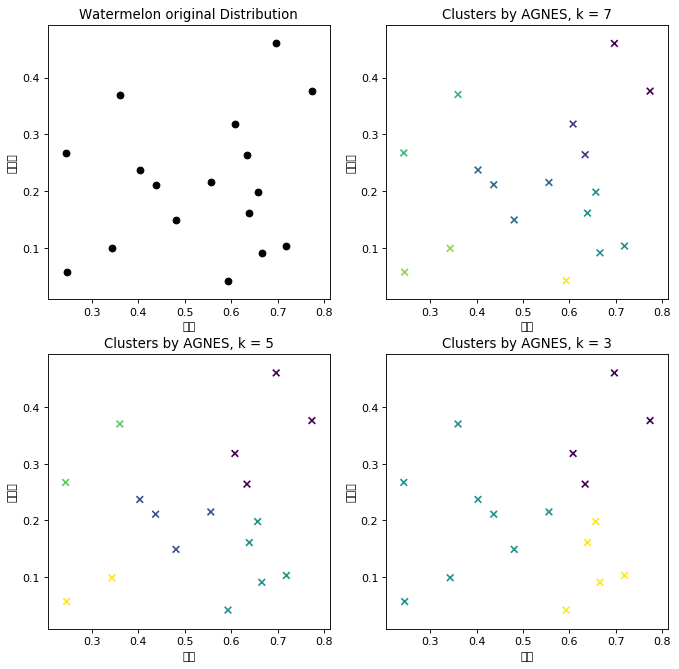

In [11]:
plt.figure(figsize=(10,10), dpi=80)
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], marker = 'o',c='black')
plt.xlabel('密度')
plt.ylabel('含糖率')
plt.title('Watermelon original Distribution')

for i,k in ((2,7),(3,5),(4,3)):
    plt.subplot(2,2,i)
    labels = hierarchical_clustering(X,k)
    plt.scatter(X[:,0], X[:,1], marker = 'x',c=labels)
    plt.xlabel('密度')
    plt.ylabel('含糖率')
    plt.title('Clusters by AGNES, k = %d'%k)

## 数据降维与度量学习
如果我们得到的数据比较高维，不适合直接使用聚类方法，则我们可以先用一些其他的无监督或有监督的技巧把数据进行降维。这一系列的方法也常常被叫做度量学习。  
度量学习，通过有监督或者无监督的方法，学习在原始的坐标距之上的距离评估方法，就是度量学习。度量学习可以为KNN和聚类服务，有时这些方法也可以被直接用在数据预处理上，而且一般表现都不错。我们首先介绍的是PCA，主成分分析；  
### PCA
PCA使用一个线性变换投影来得到新的坐标空间，也就是把原向量空间里的数据x乘上一个W矩阵，变换到另一个向量空间。PCA的目的就是确定W应该是怎样的W；考虑我们希望的是让被处理后的数据被分的尽可能开，也就是让投影后的数据点的方差最大化，问题就简化为了最大化协方差矩阵的迹。如果投影后的新向量是
\begin{equation}
W^Tx
\label{eq:linear}
\end{equation}
那么协方差矩阵就是
\begin{equation}
W^T(x-\hat{x})(x-\hat{x})^TW
\label{eq:convarience}
\end{equation}
因为W^T是投影矩阵，新的坐标基应该满足两两正交条件，还需要有约束条件
\begin{equation}
W^TW = I
\label{eq:constrain}
\end{equation}
PCA有意思就有意思在下面的步骤，我们知道如果是约束优化问题，可以用拉格朗日乘子法来解。给上面的约束条件使用拉格朗日乘子法添上一个λ，就变成
\begin{equation}
(x-\hat{x})(x-\hat{x})^TW=λW
\label{eq:lagrange multiplier}
\end{equation}
这是特征值分解的形式！特征值分解找到的特征值和特征向量对有多个，也就是满足约束条件的解有多个。对W的一个向量w，我们希望最大化的目标函数是
\begin{equation}
w^T(x-\hat{x}).(x-\hat{x})^T.w=w^Twλ=λ
\label{eq:maximize}
\end{equation}
就等于λ，最大的λ对应最好的约束优化问题的解；好了，现在拿到数据，我们把数据做个标准化，让xhat=0，然后令S = X^T.X，对S做特征值分解，在得到的λ中选k个最大的对应的特征向量，就得到W矩阵，做W.X就能把数据降维到k维。算法就结束啦。下面的代码也可以看到，只需要几行就可以实现。

In [12]:
def PCA(X,dim):
    #中心化
    xmean = np.mean(X,axis=0)
    X=deepcopy(X-xmean)
    #协方差矩阵
    Covs = X.T.dot(X)
    lamda,V=np.linalg.eigh(Covs)
    #取前dim个最大的特征值对应的特征向量
    index=np.argsort(-lamda)[:dim]
    
    diag_lamda=np.sqrt(np.diag(-np.sort(-lamda)[:dim]))
    V_selected=V[:,index]
    return V_selected

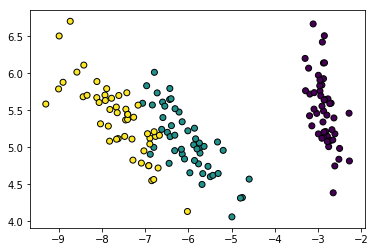

In [13]:
X,y = datasets.load_iris(return_X_y=True)

W = PCA(X,2)
X_ = X.dot(W)
plt.scatter(X_[:,0], X_[:,1],edgecolors='black',c=y)

### LDA
PCA并不总能把事情做的很好，因为PCA盲目地把数据映射到了最能"平铺"的空间。如果我们想完成二分类任务，我们的数据集像油条的两根那样平行地排布在一起，而且又被拉长，则PCA只会把油条平放在桌子上，而我们希望油条被竖直地立在桌子上，这样才能更好地区分两个类别。  
为此需要引入有标签的线性降维学习方法LDA，其实思想是和PCA完全一致，但现在我们希望最小化类内方差，最大化类间方差。事实上这部分内容在讲线性模型时已经讲过了，我们这里复习一下。  
首先定义类间距离和类内距离，类间距就是两个类中心的距离，类内距就是所有数据点到类中心的距离均值
$$J_0=((\mu_1-\mu_0)W)^T((\mu_1-\mu_0)W)=W^T(\mu_1-\mu_0)^T(\mu_1-\mu_0)W$$
$$J_1=((X-\mu)W)^T((X-\mu)W)=W^T(X-\mu)^T(X-\mu)W$$
我们设$$S_1=(X-\mu)^T(X-\mu),S_0 = (\mu_1-\mu_0)^T(\mu_1-\mu_0)$$
有了这两个量就可以自己定义损失函数了，一种能保证数据规模不会影响loss的方法是设J1=1，最大化J0。即$$J=W^TS_0W \quad s.t.\quad W^TS_1W=1$$
这个问题直接用拉格朗日乘子法就能求解，写出拉格朗日函数
$$ L(W,\lambda)=W^TS_0W-\lambda (W^TS_1W-1) $$
计算偏导并让它等于0，就得到
$$ \frac{\partial{L}} {\partial{W}}=2W^TS_0W-2\lambda W^TS_1=0 $$
$$ S_0W=\lambda S_1W $$
$$ S_1^{-1}S_0W=\lambda W $$
即特征值分解。因为我们要最大化目标函数，我们取S_1^{-1}S_0最大的特征向量，就得到了最优解W。如果我们取前d个最大的特征向量，就能实现从原数据域降维到d维的线性变换矩阵。  

In [14]:
class LDA:
    def __init__(self):
        '''
        LDA参数包括训练得到的方向向量
        和训练中留下的投影均值向量值，这里
        只设置两个mu用于二分类
        '''
        self.W = None
        self.u1 = None
        self.u2 = None
        
    def fit(self,X,y,dim):
        '''
        接收数据特征X和标签y，需要X为NxM的二维numpy array
        y为数值为0-1的一维numpy array
        '''
        # 分为正负样本
        X_1 = X[np.where(y==1)]
        X_0 = X[np.where(y==0)]
        # 计算均值
        mu1 = np.mean(X_1,axis = 0)
        mu0 = np.mean(X_0,axis = 0)
        self.mu1 = mu1
        self.mu0 = mu0
        # 类内散度
        S1 = (X_1-mu1).T.dot((X_1-mu1))
        # 类间散度
        S0 = (mu1-mu0).reshape(-1,1).dot((mu1-mu0).reshape(1,-1))
        # 特征值分解
        S = np.linalg.inv(S1).dot(S0)
        lamda,V=np.linalg.eigh(S)
        #取前dim个最大的特征值对应的特征向量
        index=np.argsort(-lamda)[:dim]
        V_selected=V[:,index]
        self.W = V_selected
        return self.W

按照我们上面说的"油条数据集"，我们自己定义一个三维的数据集来验证LDA和PCA的区别。

In [15]:
X0 = np.random.rand(50)
X1 = np.random.rand(50)
X2_1 = X0 * 0.9 + X1 * (-0.3) + 0.2
X2_2 = X0 * 0.9 + X1 * (-0.3) - 0.2
X0 = np.concatenate((X0,X0))
X1 = np.concatenate((X1,X1))
X2 = np.concatenate((X2_1,X2_2))

X = np.concatenate((X0[None],X1[None],X2[None]),axis = 0).T
y = np.concatenate((np.zeros(50),np.ones(50)))

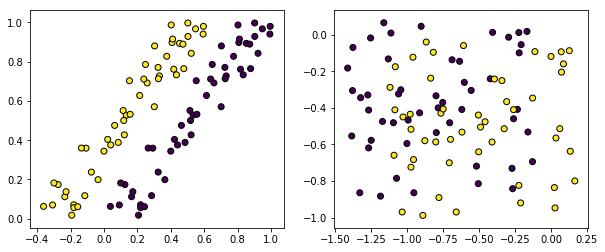

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

W = LDA().fit(X,y,2)
X_ = X.dot(W)
plt.scatter(X_[:,0], X_[:,1],edgecolors='black',c=y)

plt.subplot(1,2,2)

W = PCA(X,2)
X_ = X.dot(W)
plt.scatter(X_[:,0], X_[:,1],edgecolors='black',c=y)

### Auto Encoder
自编码器是基于PCA和神经网络的思想，我们把PCA的线性变化矩阵和神经网络的非线性激励函数叠起来，就能实现非线性降维任务。自编码器把输入当作神经网络的输出，中间的隐层需要至少一层的神经元个数少于输入层，这样就能在这一层得到神经网络自动降维后的结果。  
事实上，今天自编码器担任的不仅仅是降维的角色，相当多的研究者在使用这种模型做更多有意思的事情。比如用特殊结构的AE做字典学习，用变分的AE做生成器等等。这里我们拿pytorch的神经网络模型来实现一个自编码器。

In [17]:
import torch
import torch.nn as nn

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # 压缩
        self.encoder = nn.Sequential(
            nn.Linear(4,3),
            nn.Tanh(),
            nn.Linear(3,2),
            nn.Tanh(),
        )
        # 解压
        self.decoder = nn.Sequential(
            nn.Linear(2,3),
            nn.Tanh(),
            nn.Linear(3,4)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()

In [19]:
from torch.utils.data import DataLoader,TensorDataset

X,y = datasets.load_iris(return_X_y=True)
X_train = torch.Tensor(X)
y_train = torch.Tensor(y)

myset = TensorDataset(X_train,y_train)
myloader = DataLoader(dataset=myset, batch_size=10, shuffle=True)

In [20]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
loss_func = nn.MSELoss()
 
for epoch in range(1000):
    for step, (X_, y_) in enumerate(myloader):
        encoded, decoded = autoencoder(X_)
        loss = loss_func(decoded, X_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1)%100==0:
        print("epoch %d, loss %.2f"%(epoch+1,loss.item()))

epoch 100, loss 0.08
epoch 200, loss 0.09
epoch 300, loss 0.11
epoch 400, loss 0.06
epoch 500, loss 0.09
epoch 600, loss 0.02
epoch 700, loss 0.04
epoch 800, loss 0.03
epoch 900, loss 0.04
epoch 1000, loss 0.02


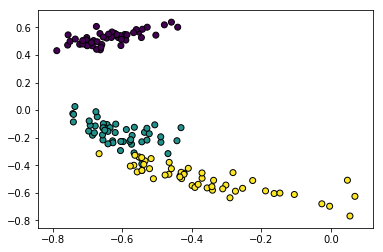

In [21]:
# 看一看结果如何
X_red,_ = autoencoder(X_train)
X_red = X_red.detach().numpy()

plt.scatter(X_red[:,0], X_red[:,1],edgecolors='black',c=y)

如果不设置激活函数，只设置两个线性变化矩阵的话，会发现得到的结果实际上和PCA得到的结果非常类似。PCA比起单隐层线性自编码器，只是多了一个正交的限制条件，而且输入的线性变化矩阵和输出的矩阵互为转置。这也就决定了线性自编码器得到的结果会和PCA很相似，但是并不会比PCA更好。